In [1]:
import os
import pathlib as path
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm
from glob import iglob
import csv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import roc_auc_score, mean_absolute_error
from IPython.display import clear_output
%matplotlib inline

In [2]:
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import DatasetFolder
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor

from torch.utils.data.dataset import random_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "drive/MyDrive/idao_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: idao_dataset/train_prep_max/NR/-0.4814000129699707__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run1_ev422;1-0.png  
  inflating: idao_dataset/train_prep_max/NR/2.226099967956543__CYGNO_60_40_He_NR_1_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run4_ev813;1-1.png  
  inflating: idao_dataset/train_prep_max/NR/2.202699899673462__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run2_ev501;1-4.png  
  inflating: idao_dataset/train_prep_max/NR/3.033900022506714__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run3_ev901;1-0.png  
  inflating: idao_dataset/train_prep_max/NR/0.19449999928474426__CYGNO_60_40_He_NR_1_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run2_ev542;1-1.png  
  inflating: idao_dataset/train_prep_max/NR/-1.1181000471115112__CYGNO_60_40_He_NR_20_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run5_ev169;1-5.png  
  inflating: idao_dataset/train_prep_max/NR/-0.34880000352859497__

In [6]:
if torch.cuda.is_available():
    print("True")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

True


#### Dataloader

In [7]:
def img_loader(path: str):
    return cv2.imread(path, cv2.IMREAD_UNCHANGED)

In [8]:
def name_to_energy(name):
    try:
        names = os.path.split(name)[-1].split("_")
        idx = [i for i, v in enumerate(names) if v == "keV"][0]
        return torch.tensor(float(names[idx - 1]))
    except Exception as e:
        return torch.tensor(-1.0)

In [9]:
#def name_to_index(self, name):
#   return os.path.split(name)[-1].split('.')[0]

In [10]:
def name_to_label(name):
    try:
        names = os.path.split(name)[-1].split("_")
        for name in names:
            if name=="ER":
                return torch.tensor(1)
            elif name=="NR":
                return torch.tensor(0)
    except Exception as e:
        return torch.tensor(-1.0)

In [11]:
class IDAODataset(Dataset):
    
    def __init__(self, main_dir, mode: ["classification", "regression"] = "classification", img_size=300):
        self.img_loader = img_loader
        self.mode = mode
        self.img_size = img_size
        self.all_imgs = list(iglob(main_dir + "**/*.png"))

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_name = self.all_imgs[idx]
        res_img = self.img_loader(img_name)
        res_img = torch.reshape(to_tensor(np.expand_dims(res_img, axis=0)), (1, self.img_size, self.img_size))
        if self.mode == "classification":
            res_target = name_to_label(img_name)
        else:
            res_target = name_to_energy(img_name)
        return res_img, res_target

In [12]:
class SplitDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        x, y = x.cuda(), y.cuda()
        return x, y
        
    def __len__(self):
        return len(self.subset)

#### Datasets

In [13]:
main_dir = "idao_dataset/train_prep_max/"

In [14]:
def split_dataset(dataset, val_part=0.05):
    percet_20 = int(val_part*len(dataset))
    train_set, val_set = random_split(
        dataset, [len(dataset)-percet_20, percet_20], generator=torch.Generator(device='cuda:0').manual_seed(666)
    )
    return train_set, val_set

#### Model

All model architecture here

In [15]:
class SimpleConv(nn.Module):
    
    def __init__(self, mode: ["classification", "regression"] = "classification"):
        super(SimpleConv, self).__init__()
        self.mode = mode
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2), # -> 300*300*8
            nn.BatchNorm2d(8),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=10, stride=10), # -> 30*30*8
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), # -> 30*30*16
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=3), # -> 10*10*16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # -> 10*10*32
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.Flatten(), 
        )
        
        self.fc = nn.Sequential( # for classification
            nn.Linear(3200, 1600),
            nn.ReLU(), 
            nn.Dropout(),
            nn.Linear(1600, 500),
            nn.ReLU(), 
            nn.Dropout(),
            nn.Linear(500, 1),
        )
        #self.fc2 = nn.Sequential( # for regression
        #    nn.ReLU(), 
        #    nn.Dropout(),
        #    nn.Linear(500, 1),
        #)
        
        self.stem = nn.Sequential(
            self.layer1, 
            nn.Dropout(), 
            self.fc,
            )
        if self.mode == "classification":
            self.classification = nn.Sequential(self.stem, nn.Sigmoid())
        else:
            self.regression = self.stem
    
    def forward(self, x):
        if self.mode == "classification":
            x = self.classification(x)
        else:
            x = self.regression(x)
        return x

Just train loop  -  nothing interesting

In [40]:
def train(network, train_loader, val_loader, epochs, learning_rate,
          mode: ["classification", "regression"] = "classification"):
    
    # init 
    if mode == "classification":
        loss = nn.BCELoss()
    else:
        loss = nn.L1Loss() # MAE
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    if mode == "classification":
        best_acc = 0
    else:
        best_acc = 100000
    
    # train loop
    try:
        for epoch in range(epochs):
            
            # epoch train
            losses = []
            accuracies = []
            network.train()
            for X, y in train_loader:
                optimizer.zero_grad()
                prediction = network(X)
                y = y.view(-1, 1)
                loss_batch = loss(prediction, y.float())
                losses.append(loss_batch.item())
                y = y.cpu().data.numpy()
                loss_batch.backward()                
                optimizer.step()

                y_pred = prediction.cpu().data.numpy()
                if mode == "classification":
                    y_pred[y_pred > 0.5] = 1
                    y_pred[y_pred <= 0.5] = 0
                    accuracies.append((y_pred==y).mean())
                else:
                    y_pred[y_pred <= 1.5] = 1 
                    y_pred[np.logical_and(y_pred > 1.5, y_pred < 4.5)] = 3
                    y_pred[np.logical_and(y_pred >= 4.5, y_pred < 8)] = 6
                    y_pred[np.logical_and(y_pred >= 8, y_pred < 15)] = 10
                    y_pred[np.logical_and(y_pred >= 15, y_pred < 25)] = 20
                    y_pred[y_pred >= 25] = 30
                    accuracies.append(mean_absolute_error(y, y_pred))
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            # epoch validation
            losses = []
            accuracies = []
            network.eval()
            with torch.no_grad():
                for X, y in val_loader:
                    prediction = network(X)
                    y = y.view(-1, 1)
                    loss_batch = loss(prediction, y.float())
                    losses.append(loss_batch.item())        
                    y = y.cpu().data.numpy()        
                    y_pred = prediction.cpu().data.numpy()
                    if mode == "classification":
                        y_pred[y_pred > 0.5] = 1
                        y_pred[y_pred <= 0.5] = 0
                        accuracies.append((y_pred==y).mean())
                    else:
                        y_pred[y_pred <= 1.5] = 1 
                        y_pred[np.logical_and(y_pred > 1.5, y_pred < 4.5)] = 3
                        y_pred[np.logical_and(y_pred >= 4.5, y_pred < 8)] = 6
                        y_pred[np.logical_and(y_pred >= 8, y_pred < 15)] = 10
                        y_pred[np.logical_and(y_pred >= 15, y_pred < 25)] = 20
                        y_pred[y_pred >= 25] = 30
                        accuracies.append(mean_absolute_error(y, y_pred))
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
            # save best model
            if mode == "classification":
                if best_acc < test_accuracy_epochs[-1]:
                    torch.save(network.state_dict(), "best_class.pickle")
                    best_acc = test_accuracy_epochs[-1]
                    upd = True
                else:
                    upd = False
            else:
                if best_acc > test_accuracy_epochs[-1]:
                    torch.save(network.state_dict(), "best_reg.pickle")
                    best_acc = test_accuracy_epochs[-1]
                    upd = True
                else:
                    upd = False


            # draw
            clear_output(True)
            if mode == "classification":
                print('\rEpoch {0}... (Train/Test) BCE: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}\t best_acc: {5:.3f}, upd: {6}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1], best_acc, upd))
            else:
                print('\rEpoch {0}... (Train/Test) MAE: {1:.3f}/{2:.3f}\tMAE after rounding: {3:.3f}/{4:.3f}\t best_acc: {5:.3f}, upd: {6}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1], best_acc, upd))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            if mode == "classification":
                plt.plot(train_accuracy_epochs, label='Train Accuracy')
                plt.plot(test_accuracy_epochs, label='Test Accuracy')
                plt.ylabel('Accuracy', fontsize=16)
            else:
                plt.plot(train_accuracy_epochs, label='Train MAE')
                plt.plot(test_accuracy_epochs, label='Test MAE')
                plt.ylabel('Loss', fontsize=16)
            plt.xlabel('Epochs', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

# Train network

#### Classification

In [78]:
mode = "classification"

Init dataset

In [85]:
class_dataset = IDAODataset(main_dir, mode)

In [86]:
class_train_set, class_val_set = split_dataset(class_dataset)

In [87]:
class_train_dataset = SplitDataset(class_train_set)
class_val_dataset = SplitDataset(class_val_set)

In [88]:
class_train_loader = DataLoader(class_train_dataset, batch_size=500,
                        shuffle=True, num_workers=0)
class_val_loader = DataLoader(class_val_dataset, batch_size=500,
                        shuffle=True, num_workers=0)

Init model

In [89]:
class_model = SimpleConv(mode)
if torch.cuda.is_available():
    print("True")
    class_model.cuda()

True


Train model

Epoch 3... (Train/Test) BCE: 0.012/0.012	Accuracy: 0.996/0.996	 best_acc: 0.996, upd: True


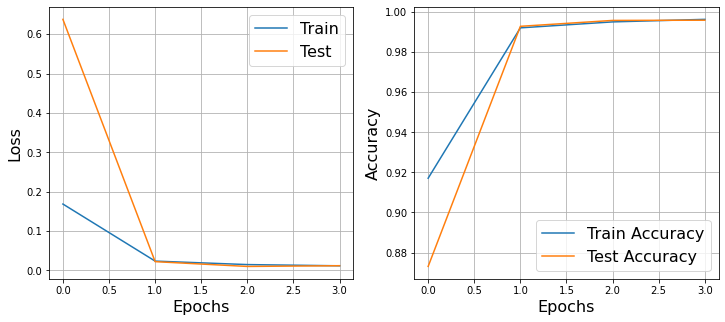

In [90]:
train(class_model, class_train_loader, class_val_loader, 7, 0.001, mode)

#### Regression

In [104]:
mode = "regression"

Init dataset

In [105]:
reg_dataset = IDAODataset(main_dir, mode)

In [106]:
reg_train_set, reg_val_set = split_dataset(reg_dataset)

In [107]:
reg_train_dataset = SplitDataset(reg_train_set)
reg_val_dataset = SplitDataset(reg_val_set)

In [108]:
reg_train_loader = DataLoader(reg_train_dataset, batch_size=500,
                        shuffle=True, num_workers=0)
reg_val_loader = DataLoader(reg_val_dataset, batch_size=500,
                        shuffle=True, num_workers=0)

Init model

In [109]:
reg_model = SimpleConv(mode)
if torch.cuda.is_available():
    reg_model.cuda()

Train model

Epoch 7... (Train/Test) MAE: 1.167/0.632	MAE after rounding: 0.300/0.053	 best_acc: 0.053, upd: True


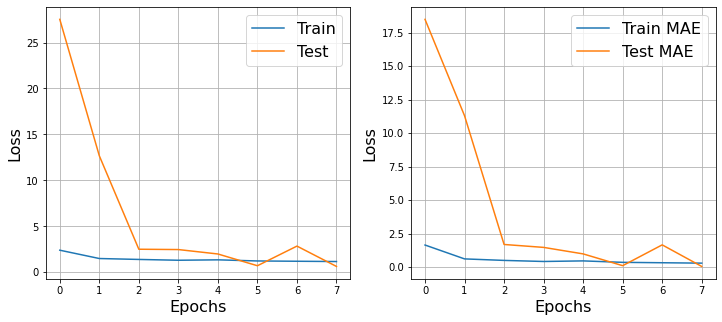

In [110]:
train(reg_model, reg_train_loader, reg_val_loader, 8, 0.001, mode)

### Submition

In [111]:
#df = pd.read_csv("track1_predictions_example.csv")

In [112]:
#df.head()

In [113]:
#df.shape

In [114]:
public_path = "idao_dataset/public_test_prep/"
private_path = "idao_dataset/private_test_prep/"

In [115]:
public_test = os.listdir(public_path)
private_test = os.listdir(private_path)

In [116]:
len(public_test), len(private_test)

(1502, 15062)

In [117]:
def submit(class_model, reg_model, threshold=0.5, round_on=False):
    with open('my_submission.csv' , 'wt') as fout:
        writer = csv.writer(fout)
        writer.writerow(['id','classification_predictions','regression_predictions'])
        # public
        for name in public_test:
            img = cv2.imread(public_path + name, cv2.IMREAD_UNCHANGED)
            res_img = torch.reshape(to_tensor(img), (1, 1, img.shape[0], img.shape[1]))
            res_img = res_img.cuda()
            # classification
            class_res = int(class_model.forward(res_img)>threshold)
            # regression
            reg_res = reg_model.forward(res_img)
            if round_on:
                if reg_res <= 1.5:
                    reg_res = 1.0
                elif reg_res <= 4.5:
                    reg_res = 3.0
                elif reg_res <= 8.0:
                    reg_res = 6.0
                elif reg_res <= 15.0:
                    reg_res = 10.0
                elif reg_res <= 25.0:
                    reg_res = 20.0
                else:
                    reg_res = 30.0
            else:
                if reg_res < 1.0:
                    reg_res = 1.0
                elif reg_res > 30.0:
                    reg_res = 30.0
                else:
                    reg_res = float(reg_res)
            # write
            writer.writerow([name[:-4], class_res, reg_res])
        # private
        for name in private_test:
            img = cv2.imread(private_path + name, cv2.IMREAD_UNCHANGED)
            res_img = torch.reshape(to_tensor(img), (1, 1, img.shape[0], img.shape[1]))
            res_img = res_img.cuda()
            # classification
            class_res = int(class_model.forward(res_img)>threshold)
            # regression
            reg_res = reg_model.forward(res_img)
            if round_on:
                if reg_res <= 1.5:
                    reg_res = 1.0
                elif reg_res <= 4.5:
                    reg_res = 3.0
                elif reg_res <= 8.0:
                    reg_res = 6.0
                elif reg_res <= 15.0:
                    reg_res = 10.0
                elif reg_res <= 25.0:
                    reg_res = 20.0
                else:
                    reg_res = 30.0
            else:
                if reg_res < 1.0:
                    reg_res = 1.0
                elif reg_res > 30.0:
                    reg_res = 30.0
                else:
                    reg_res = float(reg_res)
            # write
            writer.writerow([name[:-4], class_res, reg_res])

In [118]:
class_best = SimpleConv("classification")
class_best.load_state_dict(torch.load("best_class.pickle"))

<All keys matched successfully>

In [119]:
reg_best = SimpleConv("regression")
reg_best.load_state_dict(torch.load("best_reg.pickle"))

<All keys matched successfully>

~5 minutes...

In [120]:
submit(class_model, reg_model, round_on=True)

In [121]:
my_df = pd.read_csv("my_submission.csv")

In [122]:
my_df.head()

,id,classification_predictions,regression_predictions
0,870fa05023ba40ece55c8886ad3ae051853630fa,0,1.0
1,787df31c1e7815855a2e04b60d15d17b6ed43df2,1,3.0
2,5e08d39087d25c07222105d4d0aad94a275d6dcb,0,6.0
3,a8771be97c39e754ba35f1dacd9cfafe7bc9183c,1,30.0
4,c8bba7ea2625a956b2a47525026768a1ea141eec,1,30.0


In [ ]:
my_df.shape